In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


State: 1000, Branch: 1, Method: on_policy, Task: 1/20: 100%|██████████| 20000/20000 [00:38<00:00, 516.67it/s]
State: 1000, Branch: 1, Method: on_policy, Task: 2/20: 100%|██████████| 20000/20000 [00:39<00:00, 511.60it/s]
State: 1000, Branch: 1, Method: on_policy, Task: 3/20: 100%|██████████| 20000/20000 [00:38<00:00, 514.97it/s]
State: 1000, Branch: 1, Method: on_policy, Task: 4/20: 100%|██████████| 20000/20000 [00:39<00:00, 509.58it/s]
State: 1000, Branch: 1, Method: on_policy, Task: 5/20: 100%|██████████| 20000/20000 [00:38<00:00, 516.75it/s]
State: 1000, Branch: 1, Method: on_policy, Task: 6/20: 100%|██████████| 20000/20000 [00:38<00:00, 515.52it/s]
State: 1000, Branch: 1, Method: on_policy, Task: 7/20: 100%|██████████| 20000/20000 [00:38<00:00, 520.39it/s]
State: 1000, Branch: 1, Method: on_policy, Task: 8/20: 100%|██████████| 20000/20000 [00:38<00:00, 520.59it/s]
State: 1000, Branch: 1, Method: on_policy, Task: 9/20: 100%|██████████| 20000/20000 [00:38<00:00, 520.88it/s]
State: 100

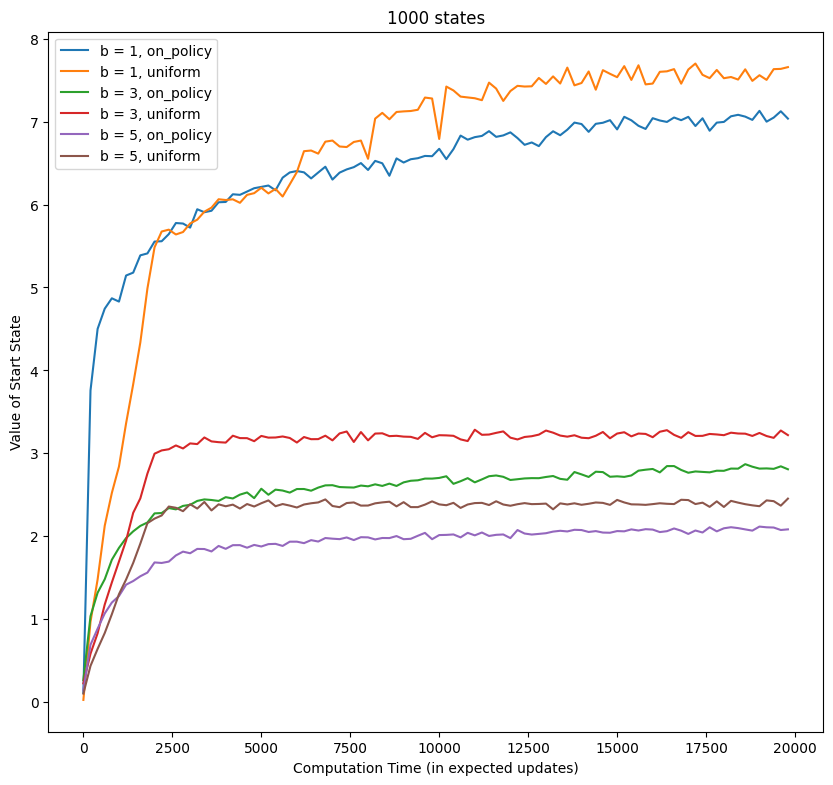

In [3]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

np.random.seed(13)


class Environment:
    def __init__(self, n_states, b, actions=[0, 1], termination_prob=0.1):
        self.n_states = n_states
        self.b = b
        self.actions = actions
        self.termination_prob = termination_prob
        self.transition = np.random.randint(n_states, size=(n_states, len(actions), b))
        self.reward = np.random.randn(n_states, len(actions), b)

    def step(self, state, action):
        if np.random.rand() < self.termination_prob:
            return self.n_states, 0
        next_ = np.random.randint(self.b)
        return self.transition[state, action, next_], self.reward[state, action, next_]

    def reset(self):
        return 0


class Simulation:
    def __init__(self, environment, max_steps=20000, eval_interval=200, epsilon=0.1):
        self.environment = environment
        self.max_steps = max_steps
        self.eval_interval = eval_interval
        self.epsilon = epsilon

    def uniform(self, pbar):
        performance = []
        q = np.zeros((self.environment.n_states, len(self.environment.actions)))
        for step in range(self.max_steps):
            state = step // len(self.environment.actions) % self.environment.n_states
            action = step % len(self.environment.actions)
            next_states = self.environment.transition[state, action]
            q[state, action] = (1 - self.environment.termination_prob) * np.mean(
                self.environment.reward[state, action] + np.max(q[next_states, :], axis=1))
            if step % self.eval_interval == 0:
                v_pi = self.evaluate_pi(q)
                performance.append([step, v_pi])
            pbar.update(1)
        return zip(*performance)

    def evaluate_pi(self, q):
        """Evaluate the value of the start state for the greedy policy."""
        runs = 1000
        returns = []
        for r in range(runs):
            rewards = 0
            state = self.environment.reset()
            while state < self.environment.n_states:
                action = argmax(q[state])
                state, reward = self.environment.step(state, action)
                rewards += reward
            returns.append(rewards)
        return np.mean(returns)

    def on_policy(self, pbar):
        performance = []
        q = np.zeros((self.environment.n_states, len(self.environment.actions)))
        state = self.environment.reset()
        for step in range(self.max_steps):
            if np.random.rand() < self.epsilon:
                action = np.random.choice(self.environment.actions)
            else:
                action = argmax(q[state])
            next_state, _ = self.environment.step(state, action)
            next_states = self.environment.transition[state, action]
            q[state, action] = (1 - self.environment.termination_prob) * np.mean(
                self.environment.reward[state, action] + np.max(q[next_states, :], axis=1))
            if next_state == self.environment.n_states:
                next_state = self.environment.reset()
            state = next_state
            if step % self.eval_interval == 0:
                v_pi = self.evaluate_pi(q)
                performance.append([step, v_pi])
            pbar.update(1)
        return zip(*performance)


def argmax(value):
    max_q = np.max(value)
    return np.random.choice([a for a, q in enumerate(value) if q == max_q])

def main():
    num_states = [1000]
    branch = [1, 3, 5]
    methods = {"on_policy": Simulation.on_policy, "uniform": Simulation.uniform}
    n_tasks = 20

    plt.figure(figsize=(10, 20))
    for i, n in enumerate(num_states):
        plt.subplot(2, 1, i + 1)
        for b in branch:
            tasks = [Environment(n, b) for _ in range(n_tasks)]
            for method_name, method in methods.items():
                value = []
                task_counter = 1
                for env in tasks:
                    sim = Simulation(env)
                    with tqdm(total=sim.max_steps, desc=f"State: {n}, Branch: {b}, Method: {method_name}, Task: {task_counter}/{n_tasks}") as pbar:
                        steps, v = method(sim, pbar)
                        value.append(v)
                    task_counter += 1
                value = np.mean(np.asarray(value), axis=0)
                plt.plot(steps, value, label=f'b = {b}, {method_name}')
        plt.title(f'{n} states')
        plt.ylabel('Value of Start State')
        plt.legend()
        plt.xlabel('Computation Time (in expected updates)')
        plt.show()

if __name__ == '__main__':
    main()

In [ ]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

np.random.seed(13)


class Environment:
    def __init__(self, n_states, b, actions=[0, 1], termination_prob=0.1):
        self.n_states = n_states
        self.b = b
        self.actions = actions
        self.termination_prob = termination_prob
        self.transition = np.random.randint(n_states, size=(n_states, len(actions), b))
        self.reward = np.random.randn(n_states, len(actions), b)

    def step(self, state, action):
        if np.random.rand() < self.termination_prob:
            return self.n_states, 0
        next_ = np.random.randint(self.b)
        return self.transition[state, action, next_], self.reward[state, action, next_]

    def reset(self):
        return 0


class Simulation:
    def __init__(self, environment, max_steps=20000, eval_interval=200, epsilon=0.1):
        self.environment = environment
        self.max_steps = max_steps
        self.eval_interval = eval_interval
        self.epsilon = epsilon

    def uniform(self, pbar):
        performance = []
        q = np.zeros((self.environment.n_states, len(self.environment.actions)))
        for step in range(self.max_steps):
            state = step // len(self.environment.actions) % self.environment.n_states
            action = step % len(self.environment.actions)
            next_states = self.environment.transition[state, action]
            q[state, action] = (1 - self.environment.termination_prob) * np.mean(
                self.environment.reward[state, action] + np.max(q[next_states, :], axis=1))
            if step % self.eval_interval == 0:
                v_pi = self.evaluate_pi(q)
                performance.append([step, v_pi])
            pbar.update(1)
        return zip(*performance)

    def evaluate_pi(self, q):
        """Evaluate the value of the start state for the greedy policy."""
        runs = 1000
        returns = []
        for r in range(runs):
            rewards = 0
            state = self.environment.reset()
            while state < self.environment.n_states:
                action = argmax(q[state])
                state, reward = self.environment.step(state, action)
                rewards += reward
            returns.append(rewards)
        return np.mean(returns)

    def on_policy(self, pbar):
        performance = []
        q = np.zeros((self.environment.n_states, len(self.environment.actions)))
        state = self.environment.reset()
        for step in range(self.max_steps):
            if np.random.rand() < self.epsilon:
                action = np.random.choice(self.environment.actions)
            else:
                action = argmax(q[state])
            next_state, _ = self.environment.step(state, action)
            next_states = self.environment.transition[state, action]
            q[state, action] = (1 - self.environment.termination_prob) * np.mean(
                self.environment.reward[state, action] + np.max(q[next_states, :], axis=1))
            if next_state == self.environment.n_states:
                next_state = self.environment.reset()
            state = next_state
            if step % self.eval_interval == 0:
                v_pi = self.evaluate_pi(q)
                performance.append([step, v_pi])
            pbar.update(1)
        return zip(*performance)


def argmax(value):
    max_q = np.max(value)
    return np.random.choice([a for a, q in enumerate(value) if q == max_q])

def main():
    num_states = [10000]
    branch = [1, 3, 5]
    methods = {"on_policy": Simulation.on_policy, "uniform": Simulation.uniform}
    n_tasks = 20

    plt.figure(figsize=(10, 20))
    for i, n in enumerate(num_states):
        plt.subplot(2, 1, i + 1)
        for b in branch:
            tasks = [Environment(n, b) for _ in range(n_tasks)]
            for method_name, method in methods.items():
                value = []
                task_counter = 1
                for env in tasks:
                    sim = Simulation(env)
                    with tqdm(total=sim.max_steps, desc=f"State: {n}, Branch: {b}, Method: {method_name}, Task: {task_counter}/{n_tasks}") as pbar:
                        steps, v = method(sim, pbar)
                        value.append(v)
                    task_counter += 1
                value = np.mean(np.asarray(value), axis=0)
                plt.plot(steps, value, label=f'b = {b}, {method_name}')
        plt.title(f'{n} states')
        plt.ylabel('Value of Start State')
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
        plt.xlabel('Computation Time (in expected updates)')
        plt.show()

if __name__ == '__main__':
    main()

State: 10000, Branch: 1, Method: on_policy, Task: 1/20: 100%|██████████| 20000/20000 [00:37<00:00, 535.27it/s]
State: 10000, Branch: 1, Method: on_policy, Task: 2/20: 100%|██████████| 20000/20000 [00:37<00:00, 528.65it/s]
State: 10000, Branch: 1, Method: on_policy, Task: 3/20: 100%|██████████| 20000/20000 [00:37<00:00, 532.47it/s]
State: 10000, Branch: 1, Method: on_policy, Task: 4/20: 100%|██████████| 20000/20000 [00:36<00:00, 549.29it/s]
State: 10000, Branch: 1, Method: on_policy, Task: 5/20: 100%|██████████| 20000/20000 [00:37<00:00, 527.46it/s]
State: 10000, Branch: 1, Method: on_policy, Task: 6/20: 100%|██████████| 20000/20000 [00:37<00:00, 530.76it/s]
State: 10000, Branch: 1, Method: on_policy, Task: 7/20: 100%|██████████| 20000/20000 [00:37<00:00, 535.38it/s]
State: 10000, Branch: 1, Method: on_policy, Task: 8/20: 100%|██████████| 20000/20000 [00:36<00:00, 549.39it/s]
State: 10000, Branch: 1, Method: on_policy, Task: 9/20: 100%|██████████| 20000/20000 [00:36<00:00, 552.87it/s]
S